# Summer 2022 Drone/VNA Data Template
Annie Polish

This template includes:
 - Loading DJI data from CSVs
 - Loading uBlox data from CSVs
 - The interpTime function to be run on the DJI data
 - Loading spectrum analyzer data from CSVs
 - Plotting all of the above data
 
The recommended usage of this file is to make a copy of it to use as a starting point for your own code.

Note that all of the file paths used here are on Rubin, so you will need to change them if you'd like to run this notebook on local data

In [2]:
# Import all the packages we'll need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import FormatStrFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime
import csv
import h5py,glob
from scipy.stats import norm

plt.rcParams.update({'font.size': 16})

# note: geopy is not included with anaconda
# install it using "pip install geopy" at a bash terminal
import geopy.distance

## Helper functions

In [2]:
# extracts frequency, magnitude, and optionally phase from a given array of VNA CSV files
def VNAtranslator(allscans, rows_to_cut=51, phase=False):
    freqs = []
    mags = []
    phases = []
    for i in range(len(allscans)):
        data = []
        with open(allscans[i], 'rt') as f:
            reader = csv.reader(f)
            for row in reader:
                 #print(row)
                data.append(row)
        data_np = np.array(data)
        print(str(i) +" - "+str(data_np[2])+": "+ str(data_np[28]))
        datafinal = data_np[rows_to_cut:-1]
        #print(datafinal)
        df=[]
        freq1 = []
        mag1 = []
        phase1 = []
        for i in datafinal:
            freq1.append(float(i[0]))
            mag1.append(float(i[1]))  
            if (phase): phase1.append(float(i[2]))
        freqs.append(freq1)
        mags.append(mag1)
        if (phase): phases.append(phase1)
            
    if (phase): return(freqs, mags, phases)
    else: return(freqs,mags)

In [3]:
# Function for adding sub-second accuracy to DJI timestamps

# last edited June 7th, 2022
# cut off last 10 rows due to ongoing GPS glitches
# added the ability to skip initial NaT rows

def interp_time(df_in):

    # find where the GPS turns on
    gps_idx = df_in[df_in.gpsUsed == True].index[0]
    
    # detect places where the GPS:dateTimeStamp column jumps backwards by a large amount, and skip them
    ts_dt = pd.to_datetime(df_in["GPS:dateTimeStamp"][gps_idx:-10])
    if np.argmin(ts_dt) > gps_idx: 
        gps_idx += np.argmin(ts_dt)
        print("Skipped a section where time ran backwards")

    # interpolate the time and see if it works out!
    while (gps_idx < len(df_in)):
        
        # find the first datetimestamp that's a real timestamp (rather than NaT)
        first_dts = df_in["GPS:dateTimeStamp"][gps_idx]
        while(type(first_dts) == type(0.1)): 
            gps_idx += 1
            first_dts = df_in["GPS:dateTimeStamp"][gps_idx]
        
        # look for where the datetimestamp ticks
        start_sec = int(first_dts[-3:-1])
        while(int(df_in["GPS:dateTimeStamp"][gps_idx][-3:-1]) == start_sec):
            gps_idx = gps_idx + 1

        # use this reference timestamp to convert the offsetTime column into proper datetimes
        start_dt = pd.to_datetime(df_in["GPS:dateTimeStamp"][gps_idx])
        offsets = np.array(df_in["offsetTime"]-df_in["offsetTime"][gps_idx])
        offsets = pd.to_timedelta(offsets, unit='s')
        timestamps = start_dt + offsets

        # put them in the dataframe
        df_in = df_in.assign(timestamp = timestamps)
        df_in = df_in.assign(UTC = timestamps)

        # check for excessive error by comparing the interpolated and uninterpolated timestamp columns
        gps_dts = pd.to_datetime(df_in["GPS:dateTimeStamp"][gps_idx:-20]).values
        interp_dts = pd.to_datetime(df_in["timestamp"][gps_idx:-20]).values
        
        if (np.mean(np.abs(gps_dts - interp_dts)/np.timedelta64(1,'ms')) < 1000):
            print("Timestamp interpolation succeeded")
            break
        else:
            print("Detected >1s error, retrying")
            gps_idx += 11 # increment the start timestamp index by an arbitrary amount and retry
    
    return df_in

## DJI data

In [4]:
# select, load, and preprocess the DJI data

# set what path to load data from
dji_path = "/hirax/all_drone_data/datcon_csv/"
fname = "FLY504"
fname = "FLY524"

# load the data
dji_df = pd.read_csv(dji_path+fname+".csv", sep=',', header=0)

# fix the timestamps
dji_df = interp_time(dji_df)
dji_df = dji_df.assign(UTC = pd.to_datetime(dji_df.timestamp, utc=True))
dji_df = dji_df.set_index('UTC')

# cut the data to only the parts where the gps is used
good_ts = dji_df[dji_df["gpsUsed"]==True].index
first_ts = good_ts[100] # arbitrarily add a 10s warmup interval
last_ts = good_ts[-10]
date_mask = (dji_df.index > first_ts) & (dji_df.index < last_ts)
dji_df = dji_df[date_mask]

/home/ap2339/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (107,142,143,144,145,146,147,148,149,150,151,364,366,368,369,1299,1390) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Timestamp interpolation succeeded


In [5]:
# searching for columns
keys = dji_df.keys()
for key in keys:
    if 'RTK' in key or 'DOWN' in key or "down" in key: print(key)

RTKdata:Date
RTKdata:Time
RTKdata:Lon_P
RTKdata:Lat_P
RTKdata:Hmsl_P
RTKdata:Lon_S
RTKdata:Lat_S
RTKdata:Hmsl_S
RTKdata:Vel_N
RTKdata:Vel_E
RTKdata:Vel_D
RTKdata:YAW
RTKdata:SVN_S
RTKdata:SVN_P
RTKdata:hdop
RTKdata:pitch
RTKdata:posFlg_0
RTKdata:posFlg_1
RTKdata:posFlg_2
RTKdata:posFlg_3
RTKdata:posFlg_4
RTKdata:posFlg_5
RTKdata:GpsState


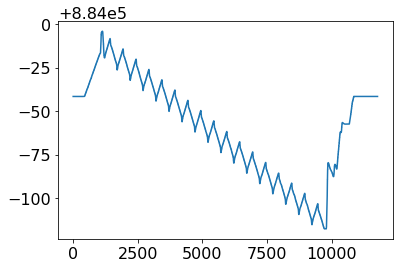

In [6]:
# TEMP CELL, DO NOT STEAL LOL

# trying to convert from lat lon height to ECEF

# use cartopy ccrs

# define the WGS84 crs
# just use ccrs.Geodetic()

# define the correct ECEF crs
# just use ccrs.Geocentric()

# extract the lat lon height columns from the DJI df
lats = dji_df["RTKdata:Lat_P"].values
lons = dji_df["RTKdata:Lon_P"].values
hmsls = dji_df["RTKdata:Hmsl_P"].values
out_coords = ccrs.Geocentric().transform_points(ccrs.Geodetic(), lats, lons, hmsls)
north, east, down = np.swapaxes(out_coords, 0, 1)

# sanity check

fig = plt.figure()
plt.plot(north[100:])
plt.show()

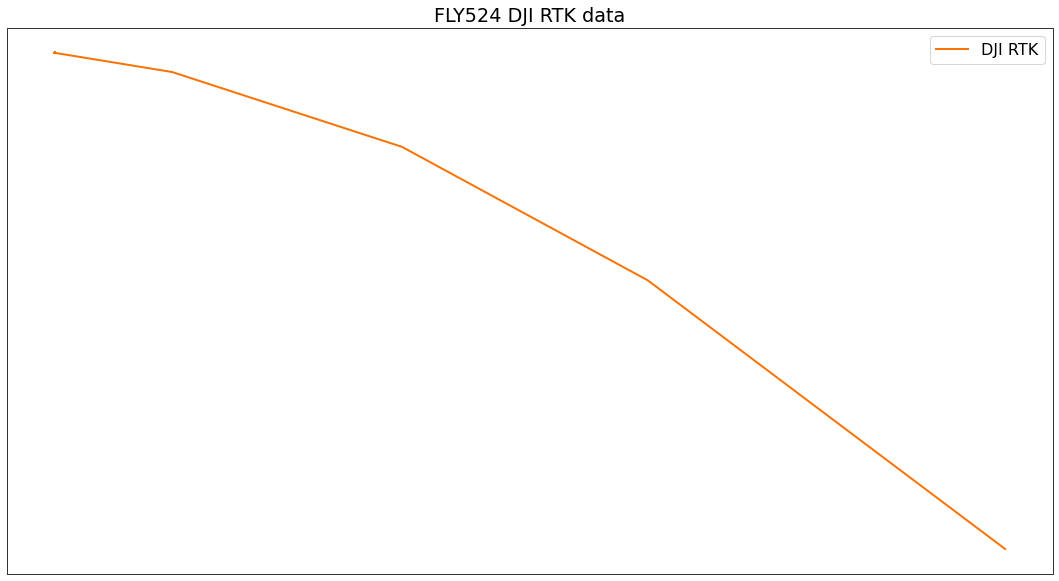

In [7]:
# plot lat/lon over google earth tiles
PLOT_BG = cimgt.GoogleTiles(style='satellite') # google earth

fig = plt.figure(figsize=(15,15))
fig.patch.set_facecolor('white')

# add a subplot in the coordinate system of the tiles
ax = fig.add_subplot(1, 1, 1, projection=PLOT_BG.crs) 

# use cartopy to add a satellite map to the background
#ax.add_image(PLOT_BG, 10) # the number here sets the zoom level (0 is far, 20 is very zoomed in)

# plot the data, transformed into the coordinate system of our plot
plt.plot(dji_df["RTKdata:Lon_P"], dji_df["RTKdata:Lat_P"], 'xkcd:orange', linewidth=2, transform=ccrs.Geodetic(), label="DJI RTK")
plt.legend()

# label and save
plt.title(fname + " DJI RTK data")
plt.tight_layout()
#plt.savefig("gps_plots/"+fname+"_map.png")
plt.show()

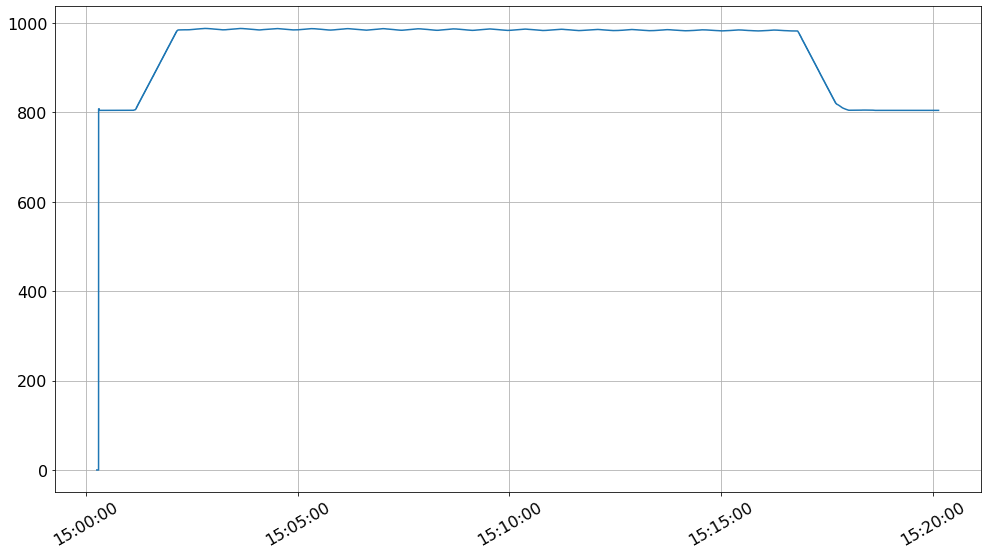

In [8]:
# plot a single column over time
fig = plt.figure(figsize=(14, 8))
plt.plot(dji_df.timestamp, dji_df["RTKdata:Hmsl_P"])

ax = plt.gca()
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M:%S"))
ax.xaxis_date()
plt.xticks(rotation=30)

plt.grid()
plt.tight_layout()
plt.show()

## uBlox data

## Column descriptions
* **iTOW**: GPS time of week in milliseconds
* **UTC**: UTC timestamp
* **tAcc**: Time accuracy estimate in nanoseconds
* **Lon**: Longitude in decimal degrees
* **Lat**: Latitude in decimal degrees
* **Height**: Height above the WGS84 ellipsoid in meters
* **HMSL**: Height above mean sea level in meters
* **hAcc**: Horizontal accuracy estimate in millimeters
* **vAcc**: Vertical accuracy estimate in millimeters
* **pDOP**: Position dilution of precision * 100 (unitless measurement of the quality of the current arrangement of satellites overhead)
* **numSV**: Number of satellites currently connected
* **velN, velE, velD**: Velocity in mm/s in NED coordinates
* **gspeed**: 2D ground speed in mm/s
* **headmot**: Heading of motion (note that this is from GPS only, not an IMU, and is not very accurate)
* **sAcc**: Speed accuracy estimate in mm/s
* **headAcc**: Heading accuracy estimate in degrees
* **fixType**: 0 for no fix, 1 for dead-reckoning, 2 for 2D fix, 3 for 3D fix, 4 for GNSS+dead reckoning, 5 for time-only. The ideal value is 3.
* **fixOK**: 1 if the fix is "OK", 0 if not. 
* **UTCvalid**: 1 if the time and date are confirmed to be correct, 0 if not
* **HPvalid**: 1 if the high precision fix if "OK", 0 if not
* **carrierSoln**: 2 if carrier phase ambiguities are fixed, 1 if they're floating, 0 if not corrected. 2 is ideal.
* **diffCorrected**: 1 if differential corrections have been applied, 0 if not

In [9]:
# select and load the uBlox data

ubx_path = "/hirax/all_drone_data/gbo_aug_21/ublox_gbo/ublox_split/"
fname = "FLY504"
    
ub_df = pd.read_csv(ubx_path+fname+"_ubx.csv", header=0)
ub_df = ub_df.assign(UTC = pd.to_datetime(ub_df.UTC))
ub_df = ub_df.set_index('UTC')

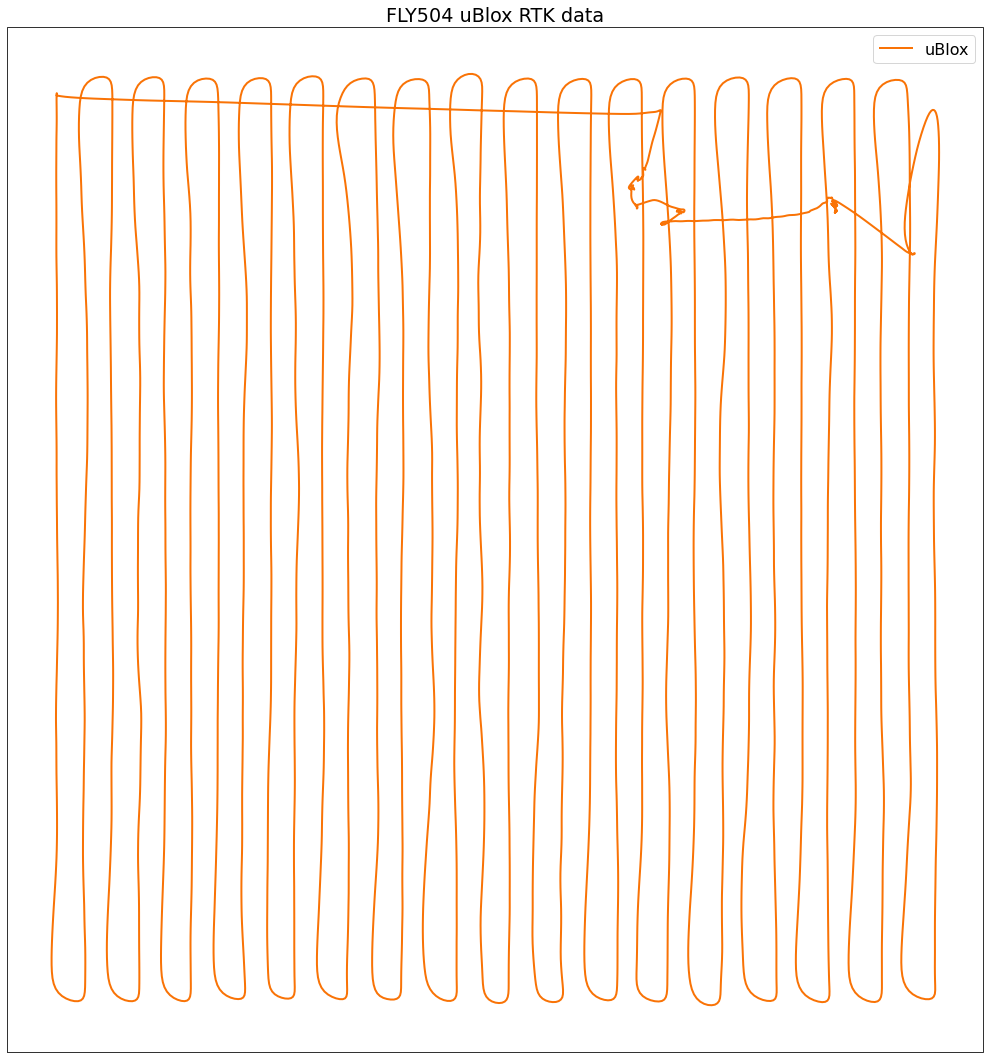

In [10]:
# plot lat/lon over google earth tiles
PLOT_BG = cimgt.GoogleTiles(style='satellite') # google earth

fig = plt.figure(figsize=(15,15))
fig.patch.set_facecolor('white')

# add a subplot in the coordinate system of the tiles
ax = fig.add_subplot(1, 1, 1, projection=PLOT_BG.crs) 

# use cartopy to add a satellite map to the background
#ax.add_image(PLOT_BG, 10) # the number here sets the zoom level (0 is far, 20 is very zoomed in)

# plot the data, transformed into the coordinate system of our plot
plt.plot(ub_df.Lon, ub_df.Lat, 'xkcd:orange', linewidth=2, transform=ccrs.Geodetic(), label="uBlox")
#plt.plot(dji_df["RTKdata:Lon_P"], dji_df["RTKdata:Lat_P"], 'cyan', linewidth=2, transform=ccrs.Geodetic(), label="DJI RTK")

plt.legend()

# label and save
plt.title(fname + " uBlox RTK data")
plt.tight_layout()
#plt.savefig("gps_plots/"+fname+"_map.png")
plt.show()

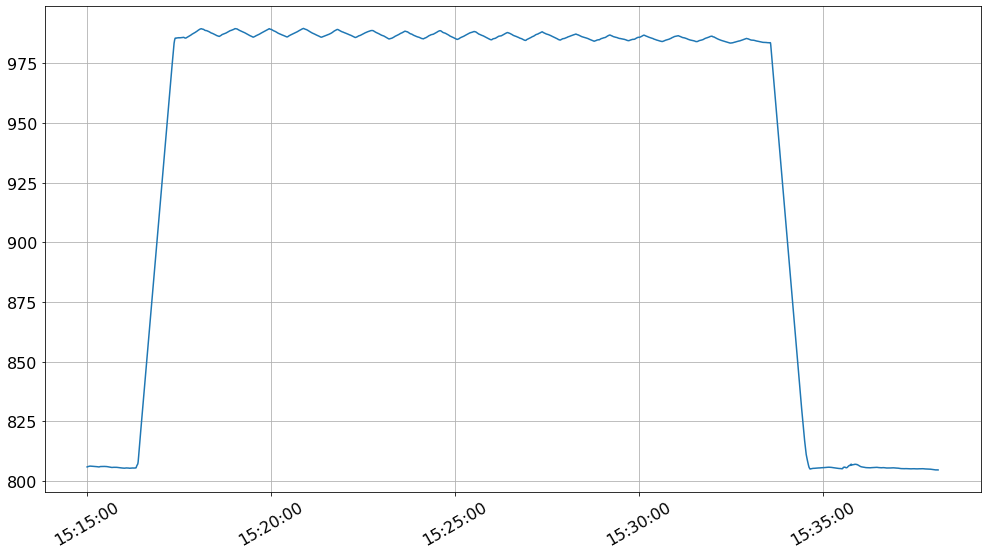

In [11]:
# plot a single column over time
fig = plt.figure(figsize=(14, 8))
plt.plot(ub_df.index, ub_df.HMSL)
ax = plt.gca()
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M:%S"))
ax.xaxis_date()
plt.xticks(rotation=30)
plt.grid()
plt.tight_layout()
plt.show()

## Spectrum analyzer/VNA data

In [12]:
# select, load, and preprocess the VNA data
vna_fileset = "/hirax/GBO_Oct_2021/spec_an_data/FSH4/gbo-1020/ns-*"

allscans=np.sort(glob.glob(vna_fileset))
freqs, mags = VNAtranslator(allscans = allscans, rows_to_cut=51)
for i in range(len(freqs)):
    freqs[i] = np.array(freqs[i])/1000000.
    mags[i] = np.array(mags[i])

0 - ['Time', '10:06:43 AM', '', '', '']: ['Trace Math', 'Off', '', '', '']
1 - ['Time', '11:00:20 AM', '', '', '']: ['Trace Math', 'Off', '', '', '']
2 - ['Time', '4:07:22 PM', '', '', '']: ['Trace Math', 'Off', '', '', '']
3 - ['Time', '4:37:52 PM', '', '', '']: ['Trace Math', 'Off', '', '', '']
4 - ['Time', '5:15:42 PM', '', '', '']: ['Trace Math', 'Off', '', '', '']
5 - ['Time', '9:43:53 AM', '', '', '']: ['Trace Math', 'Off', '', '', '']
6 - ['Time', '10:04:52 AM', '', '', '']: ['Trace Math', 'Off', '', '', '']
7 - ['Time', '10:40:44 AM', '', '', '']: ['Trace Math', 'Off', '', '', '']
8 - ['Time', '11:13:46 AM', '', '', '']: ['Trace Math', 'Off', '', '', '']
9 - ['Time', '11:43:57 AM', '', '', '']: ['Trace Math', 'Off', '', '', '']
10 - ['Time', '11:46:11 AM', '', '', '']: ['Trace Math', 'Off', '', '', '']
11 - ['Time', '12:11:29 PM', '', '', '']: ['Trace Math', 'Off', '', '', '']
12 - ['Time', '12:39:43 PM', '', '', '']: ['Trace Math', 'Off', '', '', '']
13 - ['Time', '1:07:44 PM'

<ipython-input-2-70aff197c939>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_np = np.array(data)


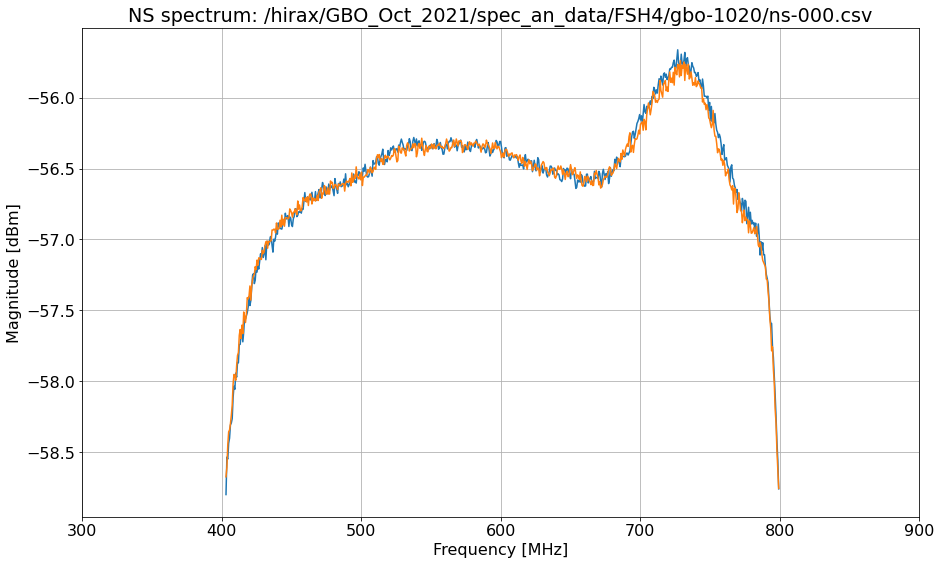

In [13]:
# plot some VNA data
plt.figure(figsize=(15,9))
plt.plot(freqs[0], mags[0])
plt.plot(freqs[1], mags[1])

plt.xlim(300, 900)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Magnitude [dBm]")
plt.grid()
plt.title("NS spectrum: "+allscans[0])
plt.show()

## Misc utility functions

This is where I'm going to put code that doesn't fit elsewhere, but that might be useful someday.

### File "stapler"
Joins 2 DJI CSV files into a single concatenated CSV file, without doing (much) additional processing

In [14]:
# the magic function
# reads the given columns from a file and returns a pandas dataframe
def process_files(filenames, output_dir="/hirax/all_drone_data/joined_csv/", input_dir="/hirax/all_drone_data/datcon_csv/"):
    frames = []
    for name in filenames:
        df = pd.read_csv(input_dir+name, sep=',', header=0)
        df = interp_time(df)
        df = df.dropna(subset=["GPS:dateTimeStamp"])
        if(df.empty): print("File "+name+" is empty. YEET")
        else: frames.append(df)
    print("STAPLING...")
    df = pd.DataFrame()
    for i, frame in enumerate(frames):
        # Re-align offsetTime so that timestamp interpolation succeeds
        # If you start having problems with timestamps in stapled files, this is the place to start looking
        # Sorry :(
        if i > 0: frame = frame.assign(offsetTime = frame.offsetTime + frames[i-1]["offsetTime"].values[-1])
        df = pd.concat([df, frame], ignore_index=True)

    if(len(frames) > 1):
        if((len(frames[0]["Tick#"].values)+len(frames[1]["Tick#"].values))==len(df["Tick#"].values)):
            print("STAPLING SUCCEEDED")
            for i in range(len(filenames) - 1):
                print("GAP # "+str(i))
                print(frames[i]["GPS:dateTimeStamp"].values[-1])
                print(frames[i+1]["GPS:dateTimeStamp"].values[0])
        else: print("ERROR: PLEASE CLEAR STAPLER JAM")
        
    # build a file name:
    if (len(filenames) > 1):
        name = ""
        for word in filenames:
            word = word.split("/")[-1]
            word = word.split(".")[0]
            name = name + word
            name = name + "_"
        name = name[:-1]
        print(name)
    else: name = filenames[0].split('/')[-1]
    df.to_csv(output_dir+name+".csv")
    return df

In [15]:
# Call the function on a pair (or more) of files to staple them together

#df_stapled = process_files(["FLY599.csv", "FLY600.csv"])
#df_stapled = process_files(["FLY630.csv", "FLY631.csv"])
df_stapled = process_files(["FLY633.csv", "FLY634.csv"])

/home/ap2339/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (107,142,143,144,145,146,147,148,149,150,151,364,368,369,1283,1351) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Timestamp interpolation succeeded


/home/ap2339/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (142,143,144,145,146,147,148,149,150,151,364,368,369,1262,1330) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Timestamp interpolation succeeded
STAPLING...
STAPLING SUCCEEDED
GAP # 0
2021-10-22T13:50:50Z
2021-10-22T13:50:50Z
FLY633_FLY634


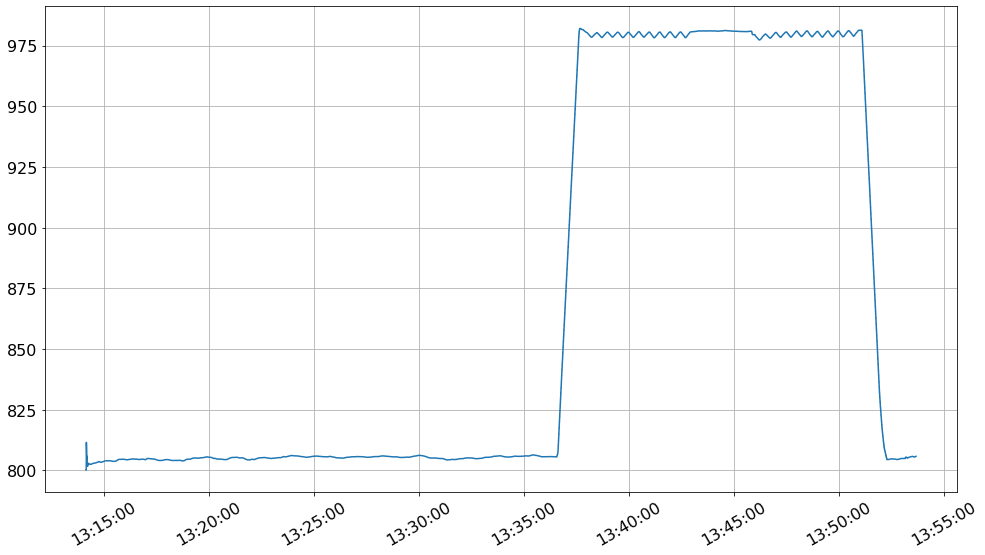

In [16]:
# Plot the height column of the stapled file to quickly check for continuity
fig = plt.figure(figsize=(14, 8))
plt.plot(df_stapled.timestamp, df_stapled["GPS(0):heightMSL"])
ax = plt.gca()
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M:%S"))
ax.xaxis_date()
plt.xticks(rotation=30)
plt.grid()
plt.tight_layout()
plt.show()

### Creating uBlox files to match DJI files

Produces the files that live at `/hirax/all_drone_data/ublox_split`.
Extracts a chunk of uBlox data to match a given DJI DAT/CSV file.

In [17]:
# define input and output paths

ubx_in_path = "/hirax/all_drone_data/gbo_oct_21/1*"
#dji_in_path = "/hirax/all_drone_data/gbo_oct_21/dji/"
dji_in_path = "/hirax/all_drone_data/joined_csv/"
exclude_list = []#["FLY599_FLY600"] # files in dji_in_path to exclude

ubx_out_path = "/hirax/all_drone_data/ublox_split/"

In [18]:
# load in all of the uBlox data and stick it together into a single giant time-series
all_ubx_paths=np.sort(glob.glob(ubx_in_path)) # np.sort on the file names will put them in chronological order :)

# read the first file
ubx_df = pd.read_csv(all_ubx_paths[0], sep=',', header=1)

# go get each additional file
for path in all_ubx_paths[1:]:
    tmp_df = pd.read_csv(path, sep=',', header=1)
    ubx_df = pd.concat([ubx_df, tmp_df], axis=0, join='inner')
    ubx_df.reset_index(drop=True, inplace=True)
    
# fix up the timestamp column
ubx_df = ubx_df.assign(UTC = pd.to_datetime(ubx_df.UTC, utc=True))
ubx_df = ubx_df.set_index('UTC')

print(type(ubx_df.index[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


['/hirax/all_drone_data/joined_csv/FLY599_FLY600.csv'
 '/hirax/all_drone_data/joined_csv/FLY630_FLY631.csv'
 '/hirax/all_drone_data/joined_csv/FLY633_FLY634.csv']


/home/ap2339/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (108,143,144,145,146,147,148,149,150,151,152,367,1391) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Detected >1s error, retrying
Detected >1s error, retrying
Detected >1s error, retrying
Detected >1s error, retrying
Detected >1s error, retrying
Timestamp interpolation succeeded
Found whole flight in uBlox file
Saved FLY599_FLY600_ubx.csv


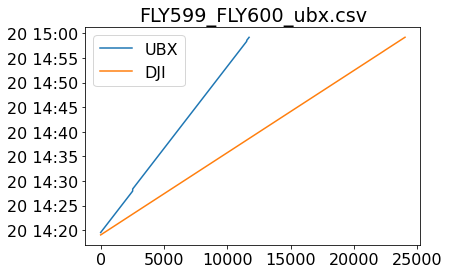

/home/ap2339/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (107,108,143,144,145,146,147,148,149,150,151,152,1350) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Detected >1s error, retrying
Detected >1s error, retrying
Detected >1s error, retrying
Detected >1s error, retrying
Detected >1s error, retrying
Detected >1s error, retrying
Timestamp interpolation succeeded
Saved FLY630_FLY631_ubx.csv


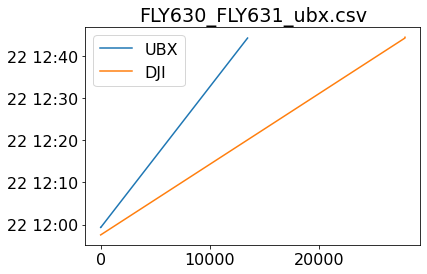

/home/ap2339/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (108,143,144,145,146,147,148,149,150,151,152,367,1352) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Timestamp interpolation succeeded
Found whole flight in uBlox file
Saved FLY633_FLY634_ubx.csv


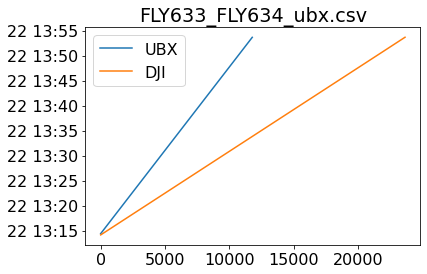

In [19]:
# enumerate all the DJI files to load
all_dji_paths = np.sort(glob.glob(dji_in_path+"*"))
print(all_dji_paths)

# iterate over all the DJI files
for dji_fname in all_dji_paths:
    if dji_fname[-10:-4] in exclude_list:
        continue
    # load in the data
    df = pd.read_csv(dji_fname, sep=',', header=0)
    #print(df)
    df = interp_time(df)
    df = df.assign(UTC = pd.to_datetime(df.timestamp, utc=True))
    df = df.set_index('UTC')
    
    # find the beginning and end of the useful data in the DJI file
    good_ts = df[df["gpsUsed"]==True].index
    if (len(good_ts) > 2):
        first_ts = good_ts[10]
        last_ts = good_ts[-10]

        # use the timestamps to index into the giant ublox df
        date_mask = (ubx_df.index > first_ts) & (ubx_df.index < last_ts)
        ubx_slice = ubx_df[date_mask]
        #print(ubx_slice)
            
        # sanity check: was the uBlox GPS even running?
        if (len(ubx_slice) < 2):
            print("WARNING: did not find matching uBlox data for "+dji_fname.split('/')[-1].split('.')[0])
            continue

        # check if we got the whole flight
        if((last_ts-first_ts)-(ubx_slice.index[-1]-ubx_slice.index[0]) > np.timedelta64(10, 's')):
            print("WARNING: more than 10 seconds of data missing in the uBlox file")
        else:
            print("Found whole flight in uBlox file")

        # save the uBlox file
        name = dji_fname.split('/')[-1].split('.')[0]+"_ubx.csv"
        ubx_slice.to_csv(ubx_out_path+name)
        print("Saved "+name)
        
        # plot timestamps as a line for a quick sanity check
        fig = plt.figure()
        plt.title(name)
        plt.plot(ubx_slice.index, label="UBX")
        plt.plot(df.index, label="DJI")
        plt.legend()
        plt.show()
        
    else:
        print("uh oh. no GPS here!")
    
    # explicitly free the df so we don't try to load all the DJI data into ram all at once
    del df

## Annie's PPK testing garbage

In [4]:
# Load in the CSV out of u-center
uncorr = pd.read_csv("./ppk_testing/LOG00010_ucenter.csv")
print(uncorr.columns)

# Load in the .pos file from RTKPOST
ppkcorr = pd.read_csv("./ppk_testing/LOG00010.pos", delim_whitespace=True, header=26)
print(ppkcorr.columns)

# Extract just the columns we care about

Index(['Index', 'UTC', 'iTOW', 'TACC', 'Lat', 'Lon', 'Alt (HAE)', 'Alt (MSL)',
       'X', 'Y', 'Z', 'PACC 3D', 'PACC H', 'PACC V', 'VX', 'VY', 'VZ', 'VN',
       'VE', 'VD', 'VACC 3D', 'PDOP', 'Fix type (GPS)', 'Fix type (GPS) valid',
       'DGPS', 'Carrier Range Status', 'SVs Used'],
      dtype='object')
Index(['%', 'GPST', 'latitude(deg)', 'longitude(deg)', 'height(m)', 'Q', 'ns',
       'sdn(m)', 'sde(m)', 'sdu(m)', 'sdne(m)', 'sdeu(m)', 'sdun(m)', 'age(s)',
       'ratio'],
      dtype='object')


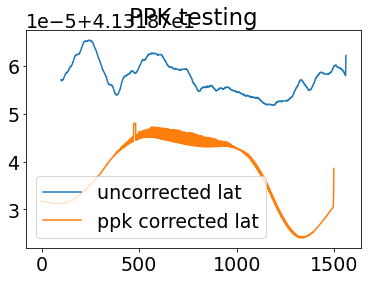

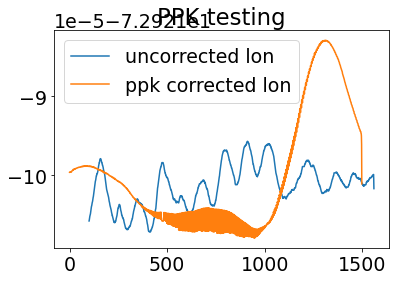

In [21]:
fig = plt.figure()
plt.title("PPK testing")
plt.plot(uncorr.Lat[100:], label="uncorrected lat")
plt.plot(ppkcorr["latitude(deg)"], label="ppk corrected lat")
plt.legend()
plt.show()

fig = plt.figure()
plt.title("PPK testing")
plt.plot(uncorr.Lon[100:], label="uncorrected lon")
plt.plot(ppkcorr["longitude(deg)"], label="ppk corrected lon")
plt.legend()
plt.show()

No handles with labels found to put in legend.


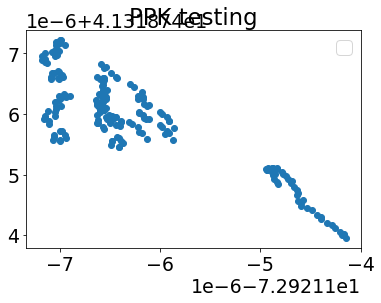

In [25]:
fig = plt.figure()
plt.title("PPK testing")
#plt.plot(uncorr.Lat[100:], uncorr.Lon[100:])
plt.scatter(ppkcorr["longitude(deg)"][500:700], ppkcorr["latitude(deg)"][500:700])
#plt.plot(ppkcorr["latitude(deg)"], label="ppk corrected lat")
plt.legend()
plt.show()

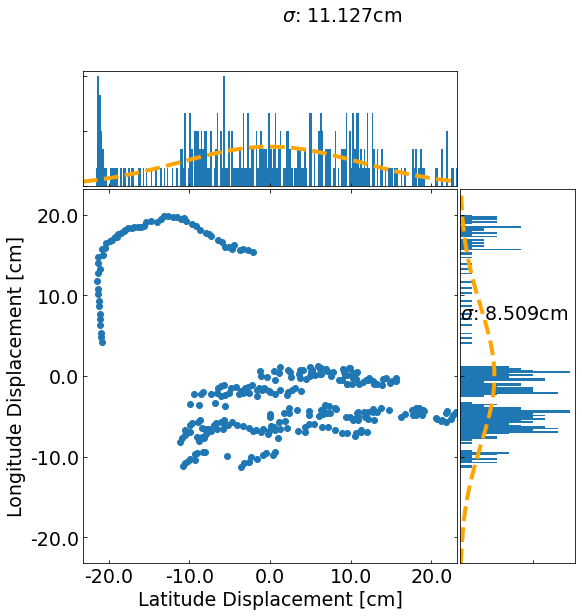

In [26]:
# the fancy point statistics plot

plt.rcParams.update({'font.size': 19})

# lat_arr = uncorr["Lat"].values[500:1000]
# lon_arr = uncorr["Lon"].values[500:1000]

lat_arr =  ppkcorr["latitude(deg)"][600:900]
lon_arr = ppkcorr["longitude(deg)"][600:900]

# convert each of the latitude and longitude arrays into a displacement from mean, in meters
center_lat = np.mean(lat_arr)
center_lon = np.mean(lon_arr)
lat_disp, lon_disp = [], []
for lat in lat_arr:
    disp = geopy.distance.distance((center_lat, center_lon), (lat, center_lon)).m*100.
    if (lat < center_lat): disp = -1.*disp
    lat_disp.append(disp)
for lon in lon_arr:
    disp = geopy.distance.distance((center_lat, center_lon), (center_lat, lon)).m*100.
    if (lon < center_lon): disp = -1.*disp
    lon_disp.append(disp)    

x = lat_disp
y = lon_disp

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
label_gap = 0.02


rect_scatter = [label_gap+left, bottom, width, height]
rect_histx = [label_gap+left, bottom + height + spacing, width, 0.2]
rect_histy = [label_gap+left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_scatter.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_scatter.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False, labelleft=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False, labelbottom=False)

# the scatter plot:
ax_scatter.scatter(x, y)

# now determine nice limits by hand:
binwidth = 0.2
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))
#ax_scatter.yaxis.set_ticks([-0.5,0,0.5])
#ax_scatter.grid()


bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins, density=True)
ax_histy.hist(y, bins=bins, orientation='horizontal', density=True)

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

# make and add gaussian fits
lat_mu, lat_sigma = norm.fit(lat_disp)
lon_mu, lon_sigma = norm.fit(lon_disp)
ax_histx.plot(bins, norm.pdf(bins, lat_mu, lat_sigma), '--', color='orange', linewidth=4)
ax_histy.plot(norm.pdf(bins, lon_mu, lon_sigma), bins, '--', color='orange', linewidth=4)
ax_histx.text(1.5, 0.15, "$\sigma$: %.3fcm"%lat_sigma)
ax_histy.text(0., 7, "$\sigma$: %.3fcm"%lon_sigma)

# LABELS LABELS LABELS
ax_scatter.set_xlabel("Latitude Displacement [cm]")
ax_scatter.set_ylabel("Longitude Displacement [cm]")

plt.show()